# PA005 - High Value Customers Identification (Insiders)

## 0.0 Planejamento da Solução (IOT)

### Input - Entrada

1. Problema de negócio
- Selecionar os clientes mais valiosos para integrar um programa de fidelização.
2. Conjunto de Dados
- Vendas de um e-commerce, durante um certo período.

### Output  - Saída
1. A indicação das pessoas que farão parte do programa de Insiders.
- Lista: client_id| is_insider |

2. Relatório com as respostas das perguntas de negócio.
- Quem são as pessoas elegíveis para participar do programa de Insiders?
- Quantos clientes farão parte do grupo?
- Quais as principais características desses clientes?
- Qual a % de contribuição do faturamento, vinda do Insiders?
- Qual a expectativa de faturamento desse grupo para os próximos meses?
- Quais as condições para uma pessoa ser elegível ao Insiders?
- Quais as condições para uma pessoa ser removida do Insiders?
- Qual a garantia que o programa Insiders é melhor que o restante da base?
- Quais ações o time de marketing pode realizar para aumentar o faturamento?

### Tasks - Tarefas


1. Quem são as pessoas elegíveis para participar do programa de Insiders?
    - O que é ser elegível? O que são clientes de alto "valor"?
    - Faturamento:
        - Alto ticket médio.
        - Alto LTV.
        - Baixa Recência.
        - Alto basket size.
        - Baixa probabilidade de Churn.
        - Alta Previsão LTV.
        - Alta propensão de compra.

    - Custo:
        - Baixa taxa de devolução.
    
    - Experiência de compra:
        - Média alta das avaliações.

2. Quantos clientes farão parte do grupo?
    - Número total de clientes.
    - % do grupo Insiders.

3. Quais as principais características desses clientes?
    - Escrever características dos clientes:
        - Idade
        - Salário
        - Localização
    
    - Escrever características de consumo:
        - Atributos de clusterização

4. Qual a % de contribuição do faturamento, vinda do Insiders?
    - Faturamento total do ano.
    - Faturamento do grupo Insiders.

5. Qual a expectativa de faturamento desse grupo para os próximos meses?
    - Previsão do LTV do grupo Insiders.
    - Análise de Cohort.

6. Quais as condições para uma pessoa ser elegível ao Insiders?
    - Definir a periodicidade ( 1 mês, 3 meses)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo.
7. Quais as condições para uma pessoa ser removida do Insiders?
    - Definir a periodicidade ( 1 mês, 3 meses)
    - A pessoa precisa ser desimilar ou não-parecido com uma pessoa do grupo.
8. Qual a garantia que o programa Insiders é melhor que o restante da base?
    - Teste A/B.
    - teste A/B Bayesiano.
    - Teste de hióteses.
9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto.
    - Preferência de compra.
    - Frete.
    - Visita a empresa.

## Benchmark de soluções

### 1.0 Desk Research

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import umap.umap_ as umap
import tensorflow as tf


from ydata_profiling import ProfileReport

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from scipy.cluster import hierarchy as hc
from plotly import express as px
import matplotlib.cm as cm
from tensorflow.keras.saving import register_keras_serializable
from matplotlib import pyplot as plt
from sklearn import cluster as c
from sklearn import preprocessing as pp
from sklearn import metrics as mt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn import mixture as mx
from sklearn.neighbors import NearestNeighbors

2024-04-12 09:24:34.521732: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 09:24:34.690174: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-12 09:24:36.905546: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 09:24:49.744340: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 0.1 Helper Functions

## 0.2 Loading Dataset

In [2]:
# load data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='latin1')

# drop extra column
df_raw = df_raw.drop('Unnamed: 8', axis = 1)

# 1.0 Descrição dos Dados

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [4]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id','country']
df1.columns = cols_new

## 1.2 Data Dimensions, Types e NA

In [5]:
df1.shape

(541909, 8)

## 1.3 Datatypes

In [6]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [7]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace NA

In [8]:
# remove na
df_missing = df1.loc[df1['customer_id'].isna(), :]
df_not_missing = df1.loc[~df1['customer_id'].isna(), :]

invoice_number_missing = df_missing.loc[:, 'invoice_no'].tolist()
df_not_missing.loc[df_not_missing['invoice_no'].isin(invoice_number_missing), :]

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country


In [9]:
df_not_missing['customer_id'].max()

18287.0

In [10]:
# create reference
df_backup = pd.DataFrame(df_missing[['invoice_no']].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000 + len(df_backup), 1)

# merge with original dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

## 1.6 Change Datatypes

In [11]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype(int)

## 1.7 Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Central Tendecy (Mean and Median)
c1 = pd.DataFrame(num_attributes.apply(lambda x: np.mean(x)))
c2 = pd.DataFrame(num_attributes.apply(lambda x: np.median(x)))

# Dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: (x).min()))
d2 = pd.DataFrame(num_attributes.apply(lambda x: (x).max()))
d3 = pd.DataFrame(num_attributes.apply(lambda x: (x).max() - (x).min()))
d4 = pd.DataFrame(num_attributes.apply(lambda x: np.std(x)))
d5 = pd.DataFrame(num_attributes.apply(lambda x: (x).skew()))
d6 = pd.DataFrame(num_attributes.apply(lambda x: (x).kurtosis()))

a = pd.concat([d1,d2,d3, c1,c2,d4,d5,d6], axis = 1)
a.columns = ['min', 'max','range','mean','median','std','skew','kurtosis']
a

,min,max,range,mean,median,std,skew,kurtosis
quantity,-80995.00,80995.0,161990.00,9.552250,3.00,218.080957,-0.264076,119769.160031
unit_price,-11062.06,38970.0,50032.06,4.611114,2.08,96.759764,186.506972,59005.719097
customer_id,12346.00,22709.0,10363.00,16688.840453,16249.00,2911.408666,0.487449,-0.804287


### 1.7.1.1 Investigating
1. Quantity negativa (pode ser devolução?)
2. Quantidade muito alta.
3. Preço unitário igual a 0 (pode ser brinde?).
4. Preço unitário alto

### 1.7.2 Categorical Attributes

In [14]:
# invoice_no

# df1['invoice_no'] = df1['invoice_no'].astype(int)
df_invoice_no = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x) ) ), :]
quantity_negative = df_invoice_no.loc[df_invoice_no['quantity'] < 0, 'quantity'].count()

print(f'Quantidade de invoice number com letras: {df_invoice_no.shape[0]} e que tem quantidade negativa: {quantity_negative}')

Quantidade de invoice number com letras: 9291 e que tem quantidade negativa: 9288


In [15]:
# stock_code

# df1['stock_code'] = df1['stock_code'].astype(int)
# len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x) ) ), 'stock_code'].drop_duplicates())

stock_code_limpeza = list(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x) ) ), 'stock_code'].unique())

print(f'Lista de stock code para limpar: {stock_code_limpeza}')

Lista de stock code para limpar: ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK']


In [16]:
# country_code
cat_attributes.loc[:, 'country'].value_counts(normalize = True)
cat_attributes.loc[:, 'country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

# 2.0 Filtragem de Variáveis

In [17]:
df2 = df1.copy()

In [18]:
# ======== unit_price ========
df2 = df2[df2['unit_price'] >= 0.04]

# ======== stock_code ========
df2 = df2[~df2['stock_code'].isin(stock_code_limpeza)]

# ======== description ========
df2 = df2.drop(columns='description', axis = 1)
 
# ======== country ========
df2 = df2[~df2['country'].isin(['European Community','Unspecified'])]

# ======== bad users ========
df2 = df2[~(df2['customer_id'].isin( [16446, 15749] ))]

# ======== quantity ========
df2_purchases = df2[df2['quantity'] >= 0]
df2_returns = df2[df2['quantity'] < 0]


# 3.0 Feature Enginnering

In [19]:
df3 = df2.copy()

## 3.1 Feature Creation

In [20]:
# data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity','invoice_date','unit_price','country'], axis = 1).drop_duplicates(ignore_index = True)

### 3.1.1 Gross Revenue

In [21]:
# Gross Revenue (Faturamento) quantity * price
df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']

# Monetary
df_monetary = df2_purchases[['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on ='customer_id', how='left')
df_ref.isna().sum()

/tmp/ipykernel_11027/4216613857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchases.loc[:, 'gross_revenue'] = df2_purchases.loc[:, 'quantity'] * df2_purchases.loc[:, 'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency Days from the last purchase

In [22]:
# Recency - Last day purchase
df_recency = df2_purchases[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchases['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id','recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchases

In [23]:
df_purch = df2_purchases.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'purchases'})
df_ref = pd.merge(df_ref, df_purch, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
purchases        91
dtype: int64

### 3.1.4 Quantity of unique products purchased

In [24]:
df_products_purch = df2_purchases.loc[:, ['customer_id','stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code': 'unique_products_purchased'})
df_ref = pd.merge(df_ref, df_products_purch, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                   0
gross_revenue                91
recency_days                 91
purchases                    91
unique_products_purchased    91
dtype: int64

### 3.1.5 Quantity of Items purchased

In [25]:
df_items_purch = df2_purchases.loc[:, ['customer_id','quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'items_purchased'})
df_ref = pd.merge(df_ref, df_items_purch, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                   0
gross_revenue                91
recency_days                 91
purchases                    91
unique_products_purchased    91
items_purchased              91
dtype: int64

### 3.1.6 Avg Ticket Value

In [26]:
df_gross = df2_purchases.loc[:, ['customer_id', 'invoice_no','gross_revenue']].groupby(['customer_id','invoice_no']).sum().reset_index()
df_ticket = df_gross.loc[:,['customer_id','gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, df_ticket, on ='customer_id', how='left')
df_ref.isna().sum()


customer_id                   0
gross_revenue                91
recency_days                 91
purchases                    91
unique_products_purchased    91
items_purchased              91
avg_ticket                   91
dtype: int64

### 3.1.7 Avg Recency Days

In [27]:
df_aux = df2[['customer_id', 'invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])
df_aux['next_customer_id'] = df_aux['customer_id'].shift()
df_aux['previous_date'] = df_aux['invoice_date'].shift()

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis = 1)

df_aux = df_aux.drop(columns=['invoice_date', 'next_customer_id', 'previous_date'], axis = 1).dropna()

df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()
df_ref = pd.merge(df_ref, df_avg_recency_days, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
dtype: int64

### 3.1.8 Frequency Purchase

In [28]:
df_aux = (df2_purchases[['customer_id','invoice_no', 'invoice_date']].drop_duplicates()
                                                           .groupby('customer_id')
                                                           .agg( max = ('invoice_date', 'max'), 
                                                                 min = ('invoice_date', 'min'),
                                                                 days_ = ('invoice_date', lambda x: ((x.max() - x.min()).days) + 1),
                                                                 buy_ = ('invoice_no', 'count')) ).reset_index()
                                                                 
df_aux['frequency'] = df_aux.apply(lambda x: x['buy_'] / x['days_'], axis = 1)

df_ref = pd.merge(df_ref, df_aux[['customer_id','frequency']], on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
dtype: int64

### 3.1.9 Number of Orders Returned

In [29]:
# Number of Returns
df_number_returns = df2_returns.loc[:, ['customer_id','invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns = {'invoice_no': 'number_returns'})
df_ref = pd.merge(df_ref, df_number_returns, on ='customer_id', how='left')
df_ref.loc[df_ref['number_returns'].isna(), 'number_returns'] = 0  
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
number_returns                  0
dtype: int64

### 3.1.10 Monetary value of returns

In [30]:
# Number of Returns
df2_returns['monetary_returns'] = df2_returns.loc[:, ['customer_id','quantity','unit_price']].apply(lambda x: x['quantity'] * x['unit_price'] * (-1), axis = 1)
df2_monetary_returns = df2_returns.loc[:, ['customer_id','monetary_returns']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df2_monetary_returns, on ='customer_id', how='left')
df_ref.loc[df_ref['monetary_returns'].isna(), 'monetary_returns'] = 0  
df_ref.isna().sum()

/tmp/ipykernel_11027/2122528216.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_returns['monetary_returns'] = df2_returns.loc[:, ['customer_id','quantity','unit_price']].apply(lambda x: x['quantity'] * x['unit_price'] * (-1), axis = 1)


customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
number_returns                  0
monetary_returns                0
dtype: int64

### 3.1.11 Basket Size - Quantity

In [31]:
df_aux = df2_purchases.loc[:, ['customer_id','invoice_no','quantity']].groupby('customer_id').agg(n_purchase = ('invoice_no', 'nunique'),
                                                                                         n_items = ('quantity', 'sum')).reset_index()
                                                                                    
df_aux['avg_basket_size'] = df_aux['n_items'] / df_aux['n_purchase']
df_aux = df_aux[['customer_id','avg_basket_size']]

df_ref = pd.merge(df_ref, df_aux, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
number_returns                  0
monetary_returns                0
avg_basket_size                91
dtype: int64

### 3.1.12 Unique Basket Size 

In [32]:
df_aux = df2_purchases.loc[:, ['customer_id','invoice_no','stock_code']].groupby('customer_id').agg(n_purchase = ('invoice_no', 'nunique'),
                                                                                         n_products = ('stock_code', 'count')).reset_index()
                                                                                    
df_aux['unique_avg_basket'] = df_aux['n_products'] / df_aux['n_purchase']
df_aux = df_aux[['customer_id','unique_avg_basket']]

df_ref = pd.merge(df_ref, df_aux, on ='customer_id', how='left')
df_ref.isna().sum()

customer_id                     0
gross_revenue                  91
recency_days                   91
purchases                      91
unique_products_purchased      91
items_purchased                91
avg_ticket                     91
avg_recency_days             2816
frequency                      91
number_returns                  0
monetary_returns                0
avg_basket_size                91
unique_avg_basket              91
dtype: int64

### 3.1.13 Delta_buy_return

In [33]:
df_ref['delta_buy_return'] = df_ref['monetary_returns'] / df_ref['gross_revenue'] 

# 4.0 EDA

In [34]:
df4 = df_ref.dropna()


## 4.1 Univariate Analysis

**Notes**
1. Clusters Coesos - Separados
2. Variabilidade
    - Métricas: Min, Máximo, Range (Dispersão)
    - Média e Mediana
    - Desvio Padrão e Variância.
    - Coeficiente de Variação. (comparar fundo de investimento)

**Notes**
1. Gross Revenue - Variabilidade Alta
2. Recency Days - Variabilidade
3. Purchases - Variabilidade
4. Unique Products Purchased - Variabilidade Média
5. Items Purchased - Alta Variabilidade
6. Avg Ticket 
    - Hipótese: Alta variabilidade mas muito causada pelos outliers errados
    - Sem um Outlier ficou variabilidade normal
7. Avg recency days - Baixa Variabilidade
8. Frequency - Alta Variabilidade
9. Number of Returns - Variabilidade Média
10. Monetary Returns - 
    - Hipótese - Variabilidade alta devido ao outlier
    - Variabilidade é alta
11. Avg basket size 
    - Hipótese - Variabilidade alta devido ao outlier
    - Variabilidade normal
12. Unique Avg Basket Size - Baixa variabilidade
13. Delta Buy Return - Alta variabilidade

In [35]:
# df_test_report = df4[(df4['customer_id'] != 16446)]
# profile = ProfileReport(df_test_report)
# profile.to_file('output_test.html')

In [36]:
# profile = ProfileReport(df4)
# profile.to_file('output.html')


### 4.1.1 Gross Revenue

In [37]:
df3[df3['customer_id'] == 14646].sort_values('quantity', ascending = False)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
421601,573003,23084,2400,2017-10-25,2.08,Netherlands,14646
409248,572052,22595,1728,2017-10-18,0.72,Netherlands,14646
63444,541570,21212,1440,2017-01-17,0.42,Netherlands,14646
534952,581175,23084,1440,2017-12-05,1.79,Netherlands,14646
186820,552883,21212,1200,2017-05-10,0.42,Netherlands,14646
...,...,...,...,...,...,...,...
271586,560710,23296,1,2017-07-18,1.25,Netherlands,14646
271584,560710,22567,1,2017-07-18,1.45,Netherlands,14646
271585,560710,23297,1,2017-07-18,1.65,Netherlands,14646
319805,C564899,22956,-144,2017-08-29,1.85,Netherlands,14646


In [38]:
df3[df3['customer_id'] == 18102].sort_values('quantity', ascending = True)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
439226,574383,23404,1,2017-11-02,3.26,United Kingdom,18102
439225,574383,82484,1,2017-11-02,4.80,United Kingdom,18102
373027,569257,23404,2,2017-10-01,3.26,United Kingdom,18102
439228,574383,22188,2,2017-11-02,2.31,United Kingdom,18102
439114,574355,22189,4,2017-11-02,2.31,United Kingdom,18102
...,...,...,...,...,...,...,...
540061,581457,23543,698,2017-12-06,4.15,United Kingdom,18102
16428,537657,22188,972,2016-12-05,2.31,United Kingdom,18102
16427,537657,22189,972,2016-12-05,2.31,United Kingdom,18102
16436,537659,22188,1008,2016-12-05,2.31,United Kingdom,18102


### 4.1.2 Purchases
- Cliente 12748 e 14911 compras ok

### 4.1.3 Items Purchased

In [39]:
df3[df3['customer_id'] == 14646	].sort_values('quantity', ascending = False)

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
421601,573003,23084,2400,2017-10-25,2.08,Netherlands,14646
409248,572052,22595,1728,2017-10-18,0.72,Netherlands,14646
63444,541570,21212,1440,2017-01-17,0.42,Netherlands,14646
534952,581175,23084,1440,2017-12-05,1.79,Netherlands,14646
186820,552883,21212,1200,2017-05-10,0.42,Netherlands,14646
...,...,...,...,...,...,...,...
271586,560710,23296,1,2017-07-18,1.25,Netherlands,14646
271584,560710,22567,1,2017-07-18,1.45,Netherlands,14646
271585,560710,23297,1,2017-07-18,1.65,Netherlands,14646
319805,C564899,22956,-144,2017-08-29,1.85,Netherlands,14646


In [40]:
df4[df4['items_purchased'] == 196844]

,customer_id,gross_revenue,recency_days,purchases,unique_products_purchased,items_purchased,avg_ticket,avg_recency_days,frequency,number_returns,monetary_returns,avg_basket_size,unique_avg_basket,delta_buy_return
1017,14646,279138.02,1.0,72.0,2060.0,196844.0,3876.916944,7.844444,0.20339,1.0,360.0,2733.944444,28.611111,0.00129


### 4.1.4 AVG Ticket Value
- Customer 16446 - 2 compras efetivas e uma de 80995 itens que devolveu em seguida. 
- Customer 15749 - muitas compras devolvidas e de alto valor e metade do Gross Revenue foi devolvido.

### 4.1.5 Frequency
- Customer 17850 (frequência 17) ok

### 4.1.6 Number of Returns


In [41]:
df3[(df3['customer_id'] == 17841) & (df3['quantity'] < 0)].drop_duplicates('invoice_no')

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
1441,C536543,22632,-1,2016-11-29,2.10,United Kingdom,17841
6782,C536979,84685,-1,2016-12-01,3.75,United Kingdom,17841
58588,C541254,21667,-2,2017-01-14,14.95,United Kingdom,17841
64523,C541641,21671,-1,2017-01-18,1.25,United Kingdom,17841
68072,C541852,21781,-1,2017-01-21,14.95,United Kingdom,17841
88796,C543817,22179,-1,2017-02-11,6.75,United Kingdom,17841
93807,C544310,79160,-1,2017-02-15,2.10,United Kingdom,17841
104698,C545189,47594B,-1,2017-02-26,1.95,United Kingdom,17841
112062,C545866,21424,-1,2017-03-05,2.95,United Kingdom,17841
112065,C545867,21424,-1,2017-03-05,2.95,United Kingdom,17841


### 4.1.7 Monetary of Returns
- Customer 16029 - apesar de ter um delta positivo, realizou muitas devoluções


In [42]:
df3[(df3['customer_id'] == 16029) & (df3['quantity'] < 0)]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
43331,C540030,22070,-24,2017-01-02,3.75,United Kingdom,16029
121098,C546735,22933,-144,2017-03-14,2.10,United Kingdom,16029
121099,C546735,22932,-96,2017-03-14,2.10,United Kingdom,16029
121100,C546735,22930,-96,2017-03-14,2.10,United Kingdom,16029
390498,C570552,85099F,-100,2017-10-09,1.74,United Kingdom,16029
390499,C570552,85099B,-300,2017-10-09,1.74,United Kingdom,16029
390500,C570552,22961,-192,2017-10-09,1.25,United Kingdom,16029
390501,C570552,22386,-200,2017-10-09,1.74,United Kingdom,16029
390502,C570552,22207,-72,2017-10-09,3.75,United Kingdom,16029
390503,C570552,21931,-100,2017-10-09,1.74,United Kingdom,16029


In [43]:
df4[(df4['customer_id'] == 16029)]

,customer_id,gross_revenue,recency_days,purchases,unique_products_purchased,items_purchased,avg_ticket,avg_recency_days,frequency,number_returns,monetary_returns,avg_basket_size,unique_avg_basket,delta_buy_return
12,16029,72882.09,38.0,62.0,241.0,40207.0,1175.517581,9.054054,0.184524,4.0,14688.24,648.5,3.887097,0.201534


### 4.1.8 Avg Basket Size
- Customer 16446 - 80997 itens em uma compra mas devolveu tudo
- Customer 15749 - Comprou muitos itens em poucas compras mas devolveu muito.


### 4.1.9 Unique Avg Basket Size
- Outliers ok


### 4.1.10 Delta Buy Returns
- 3 clientes que tem um delta negativo, talvez tenham compras anteriores a data inicial da base de dados



In [44]:
df4[df4['delta_buy_return'] < 1]

,customer_id,gross_revenue,recency_days,purchases,unique_products_purchased,items_purchased,avg_ticket,avg_recency_days,frequency,number_returns,monetary_returns,avg_basket_size,unique_avg_basket,delta_buy_return
0,17850,5391.21,372.0,34.0,297.0,1733.0,158.565000,35.500000,17.000000,1.0,102.58,50.970588,8.735294,0.019027
1,13047,3232.59,56.0,9.0,171.0,1390.0,359.176667,27.250000,0.028302,7.0,143.49,154.444444,19.000000,0.044389
2,12583,6705.38,2.0,15.0,232.0,5028.0,447.025333,23.187500,0.040323,2.0,76.04,335.200000,15.466667,0.011340
3,13748,948.25,95.0,5.0,28.0,439.0,189.650000,92.666667,0.017921,0.0,0.00,87.800000,5.600000,0.000000
4,15100,876.00,333.0,3.0,3.0,80.0,292.000000,8.600000,0.073171,3.0,240.90,26.666667,1.000000,0.275000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5653,14893,1237.85,9.0,2.0,73.0,799.0,618.925000,2.000000,0.666667,0.0,0.00,399.500000,36.500000,0.000000
5657,12479,473.20,11.0,1.0,30.0,382.0,473.200000,4.000000,1.000000,2.0,49.90,382.000000,30.000000,0.105452
5678,14126,706.13,7.0,3.0,15.0,508.0,235.376667,3.000000,0.750000,1.0,62.50,169.333333,5.000000,0.088511
5684,13521,1092.39,1.0,3.0,435.0,733.0,364.130000,4.500000,0.300000,0.0,0.00,244.333333,145.000000,0.000000


## 4.2 Bivariate Analysis

In [45]:
cols = ['customer_id']
df42 = df4.drop(cols, axis = 1)

In [46]:
# plt.figure(figsize=(20, 5))
# sns.pairplot(df42)

**Notes** 
1. Frequency has low variance.
2. Avg ticket has low variance.
3. Monetary returns has low variance.

## 4.3 Estudo do Espaço

In [47]:
df43 = df4.drop(columns=['customer_id'], axis = 1).copy()


In [48]:
mms = pp.MinMaxScaler()

In [49]:
df43['gross_revenue'] = mms.fit_transform(df43[['gross_revenue']])
df43['recency_days'] = mms.fit_transform(df43[['recency_days']])
df43['purchases'] = mms.fit_transform(df43[['purchases']])
df43['unique_products_purchased'] = mms.fit_transform(df43[['unique_products_purchased']])
df43['items_purchased'] = mms.fit_transform(df43[['items_purchased']])
df43['avg_ticket'] = mms.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days'] = mms.fit_transform(df43[['avg_recency_days']])
df43['frequency'] = mms.fit_transform(df43[['frequency']])
df43['number_returns'] = mms.fit_transform(df43[['number_returns']])
df43['monetary_returns'] = mms.fit_transform(df43[['monetary_returns']])
df43['avg_basket_size'] = mms.fit_transform(df43[['avg_basket_size']])
df43['unique_avg_basket'] = mms.fit_transform(df43[['unique_avg_basket']])
df43['delta_buy_return'] = mms.fit_transform(df43[['delta_buy_return']])

X = df43.copy()
X = X.drop(['gross_revenue'], axis = 1)


### 4.3.1 PCA

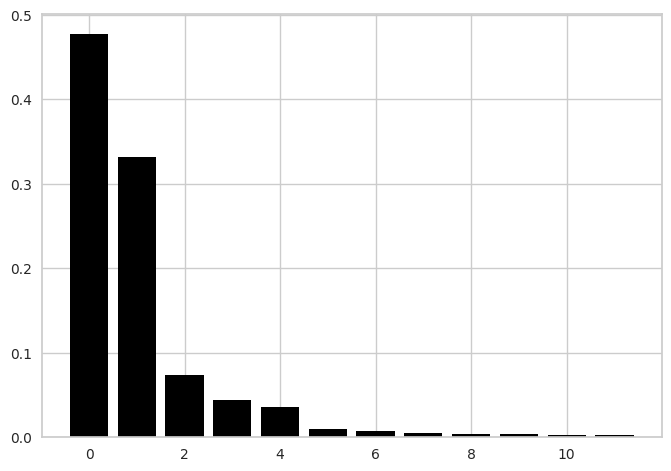

In [50]:

pca = PCA(n_components=X.shape[1])
principals_components = pca.fit_transform(X)

# Plot explained variance ratio
features = range(pca.n_components_)

plt.rcParams['font.family'] = 'DejaVu Sans'

plt.bar(features, pca.explained_variance_ratio_, color = 'black')
plt.show()

# pca component
df_pca = pd.DataFrame(principals_components)

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='0', ylabel='1'>

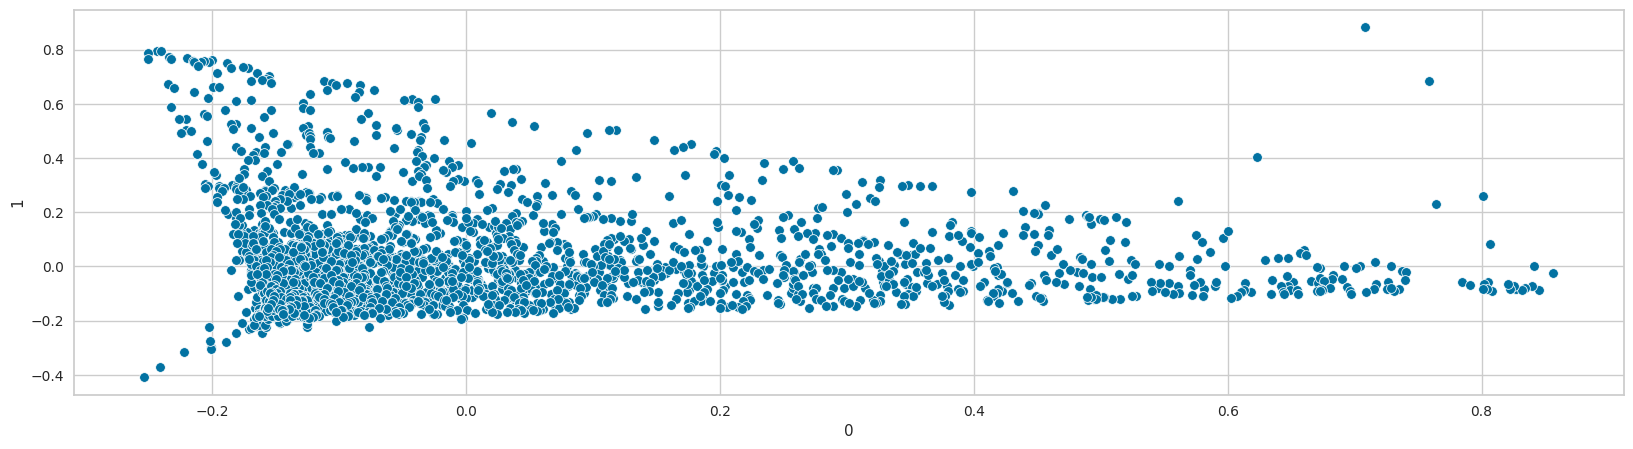

In [51]:
plt.figure(figsize=(20,5))
sns.scatterplot(x=0, y=1, data = df_pca)

### 4.3.2 UMAP

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

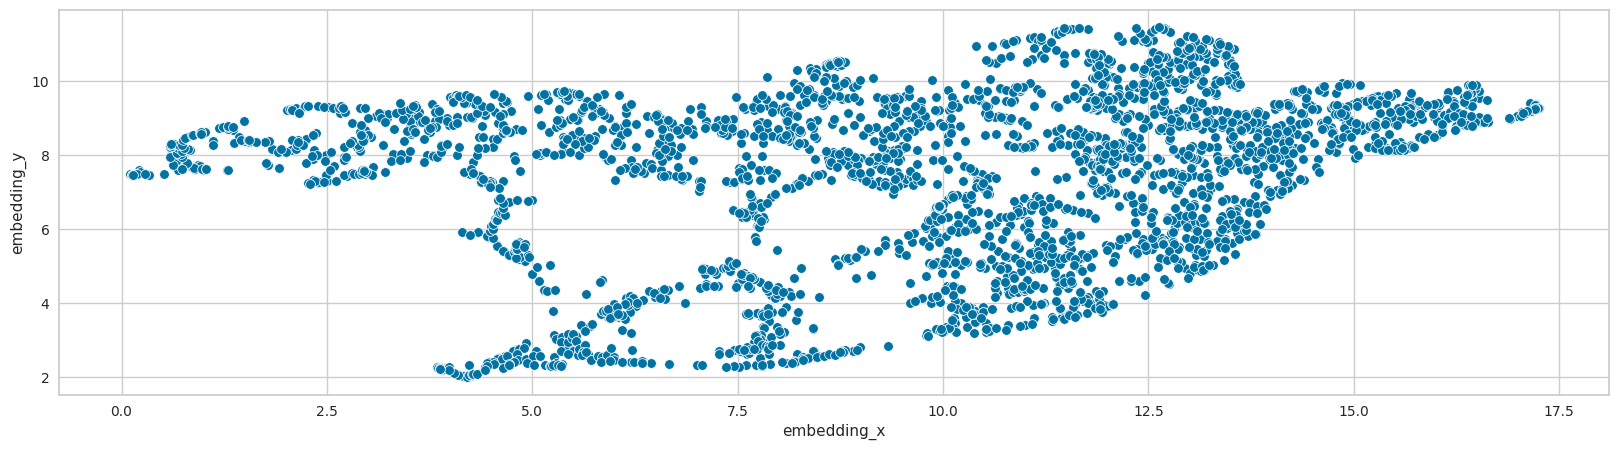

In [52]:
reducer = umap.UMAP(random_state= 42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(20,5))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca)


### 4.3.3 t-SNE

In [53]:
from sklearn.manifold import TSNE

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='embedding_x', ylabel='embedding_y'>

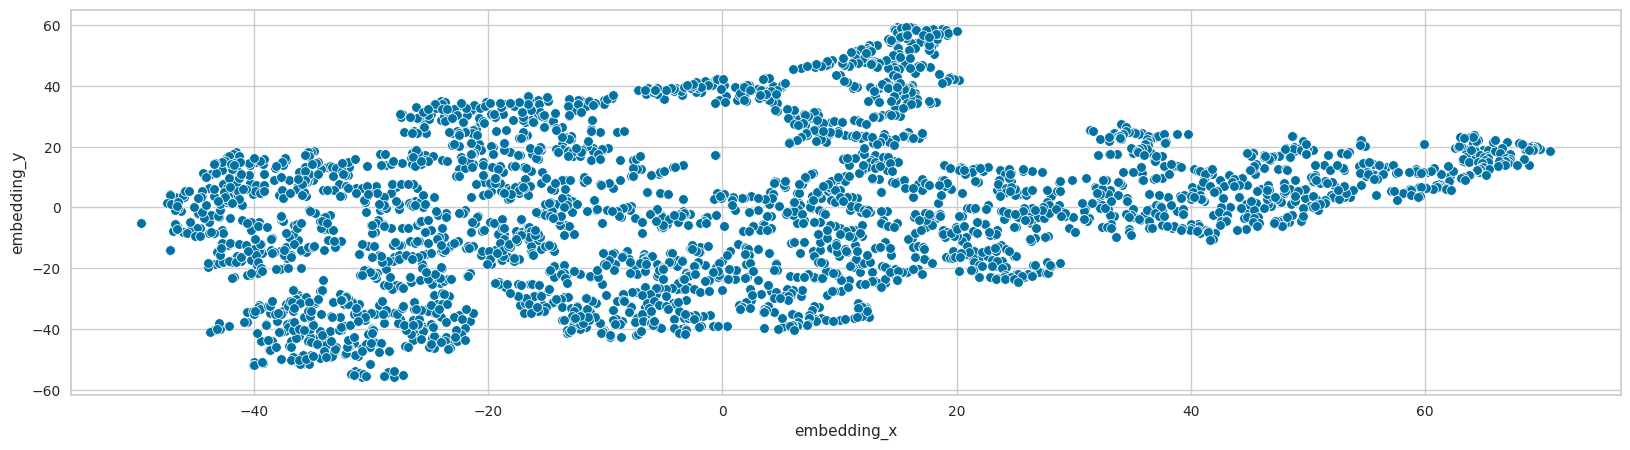

In [54]:
reducer = TSNE(n_components = 2, n_jobs = -1 ,random_state= 42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(20,5))
sns.scatterplot(x='embedding_x', y='embedding_y', data = df_pca)


### 4.3.4 Tree Based Embedding

In [55]:
y = df4['gross_revenue'].copy()
# model definition
rf_model = RandomForestRegressor(n_estimators= 250, random_state=42)
# model training
rf_model.fit(X, y)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

df = pd.DataFrame()
for i, j in zip (X, rf_model.feature_importances_):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis = 0)
feature_selected = df.loc[df['importance'] > 0.01, 'feature'].tolist()

In [56]:
feature_selected = ['items_purchased',
 'avg_ticket',
 'number_returns',
 'monetary_returns',
 'delta_buy_return','recency_days']

In [57]:
# training dataset
X1 = X[feature_selected]

y = df4['gross_revenue'].copy()

# model definition
rf_model = RandomForestRegressor(n_estimators= 250, random_state=42)
# model training
rf_model.fit(X1, y)

# df leaf
df_leaf = pd.DataFrame(rf_model.apply(X1))


In [58]:
reducer = umap.UMAP(n_components= 10, random_state= 42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_tree = pd.DataFrame()
# df_tree
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]
df_tree['embedding_z'] = embedding[:, 2]
df_tree['embedding_a'] = embedding[:, 3]
df_tree['embedding_b'] = embedding[:, 4]
df_tree['embedding_c'] = embedding[:, 5]
df_tree['embedding_d'] = embedding[:, 6]
df_tree['embedding_e'] = embedding[:, 7]
df_tree['embedding_f'] = embedding[:, 8]
df_tree['embedding_g'] = embedding[:, 9]



# df4 
df4['embedding_x'] = embedding[:, 0]
df4['embedding_y'] = embedding[:, 1]
df4['embedding_z'] = embedding[:, 2]
df4['embedding_a'] = embedding[:, 3]
df4['embedding_b'] = embedding[:, 4]
df4['embedding_c'] = embedding[:, 5]
df4['embedding_d'] = embedding[:, 6]
df4['embedding_e'] = embedding[:, 7]
df4['embedding_f'] = embedding[:, 8]
df4['embedding_g'] = embedding[:, 9]



/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/tmp/ipykernel_11027/66581022.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['embedding_x'] = embedding[:, 0]
/tmp/ipykernel_11027/66581022.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='embedding_x', ylabel='embedding_a'>

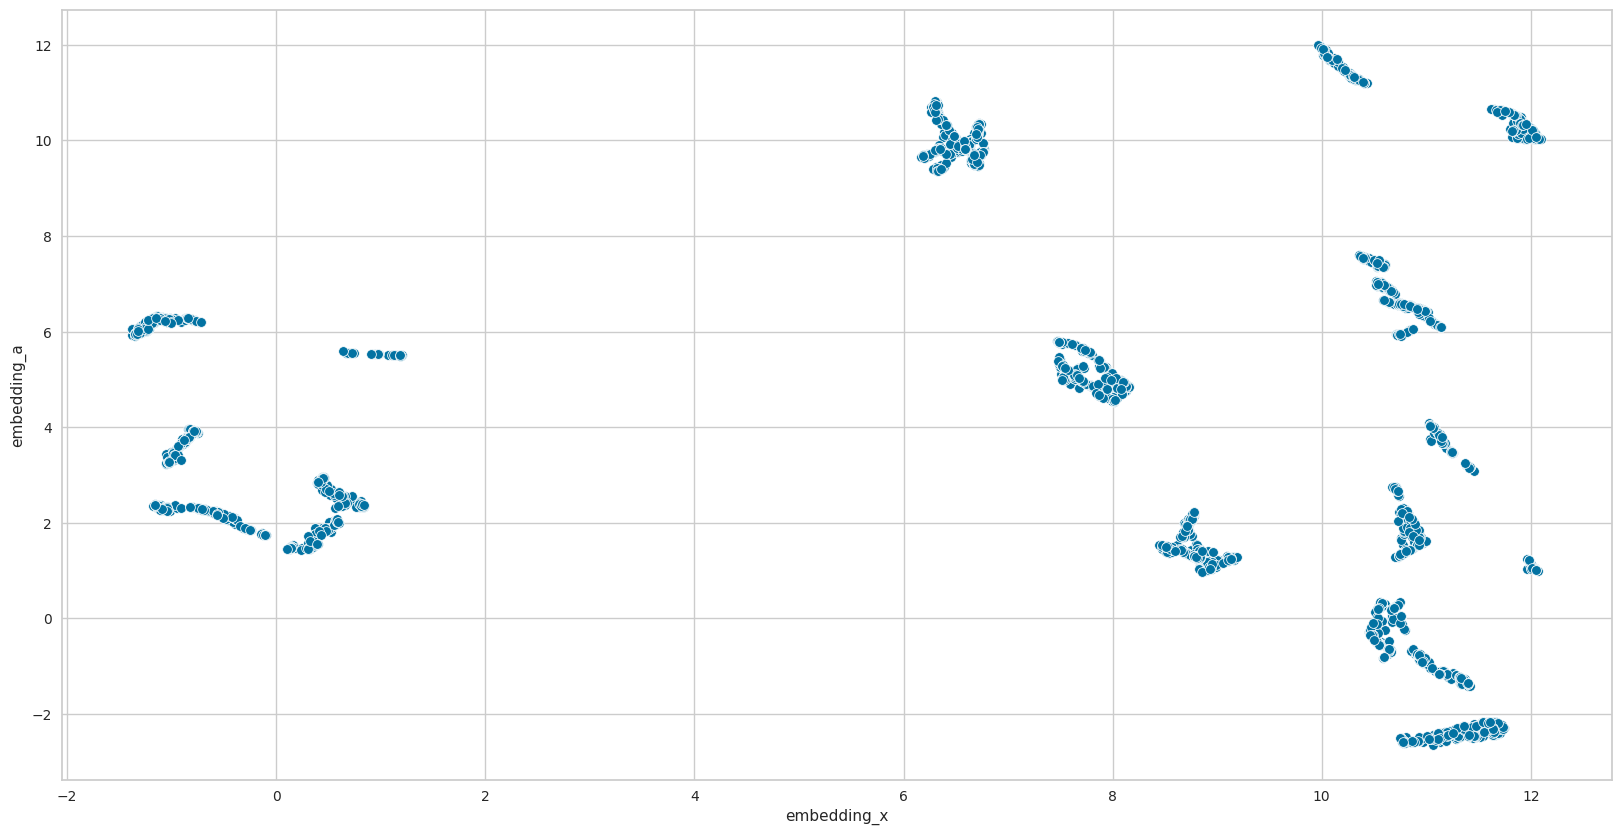

In [59]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='embedding_x', y='embedding_a', data = df_tree)

# 5.0 Data preparation

In [60]:
df5 = df_tree.copy()

# 6.0 Feature Selection

In [61]:
df6 = df5.copy()

# 7.0 HyperParameter Fine-Tunning

In [62]:
X = df6.copy()

In [63]:
clusters = np.arange(2, 26, 1)

## 7.1 K-Means

In [64]:
kmeans_list = []
for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters= k)

    # model fit
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    ss = mt.silhouette_score(X, labels)
    kmeans_list.append(ss)

Text(0.5, 1.0, 'Silhouette x K - Kmeans')

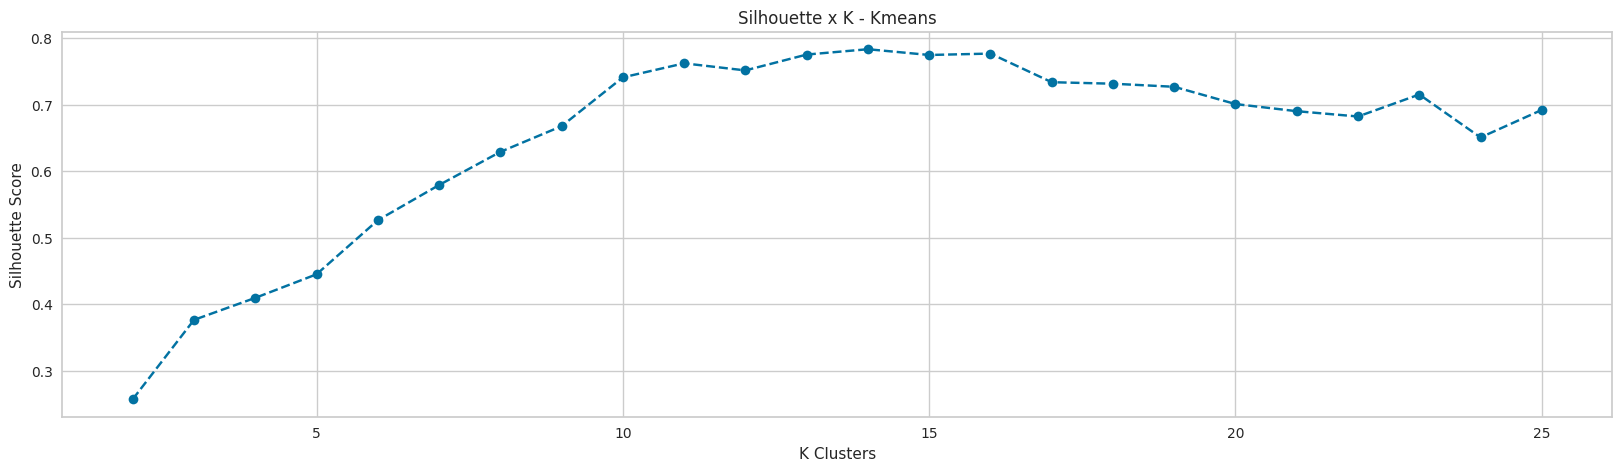

In [65]:
plt.figure(figsize=(20, 5))
plt.plot(clusters, kmeans_list, linestyle= '--', marker = 'o')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette x K - Kmeans')

## 7.2 GMM

In [66]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components = k, random_state = 42)

    # model fit
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)

    # model performance
    ss = mt.silhouette_score(X, labels)
    gmm_list.append(ss)

Text(0.5, 1.0, 'Silhouette x K - GMM')

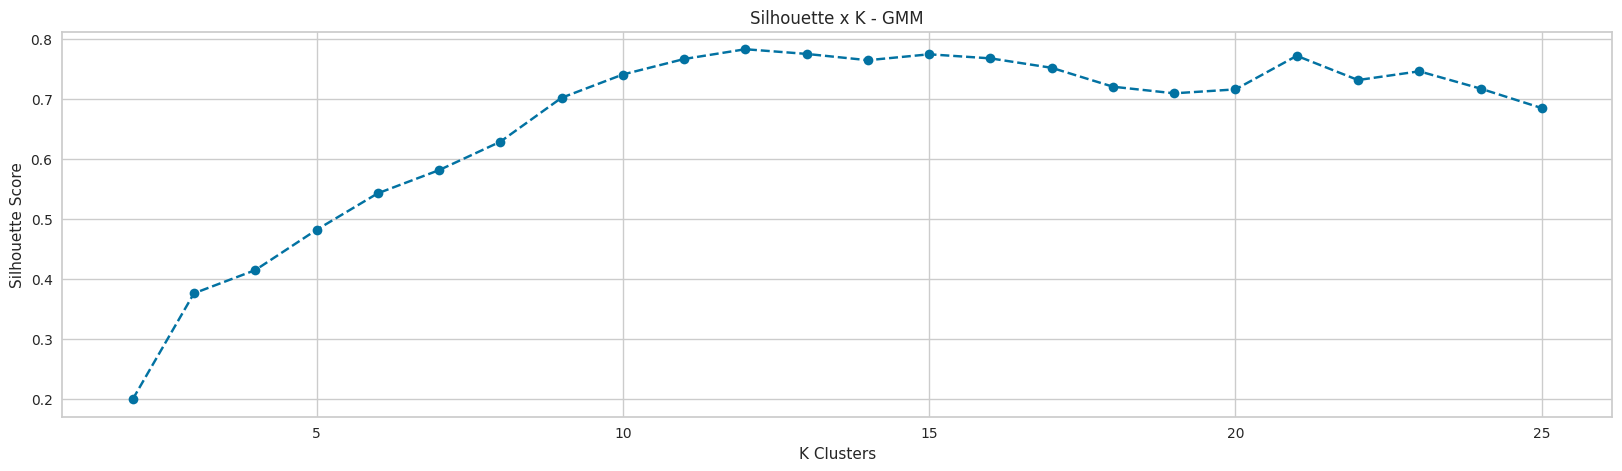

In [67]:
plt.figure(figsize=(20, 5))
plt.plot(clusters, gmm_list, linestyle= '--', marker = 'o')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette x K - GMM')

## 7.3 H-Clustering

### 7.3.1 Dendrogram

In [68]:
# model definition and training
hc_model = hc.linkage(X, method='ward')

In [69]:
# plt.figure(figsize=(20,5))
# hc.dendrogram(
#     hc_model,
#     leaf_rotation = 90,
#     leaf_font_size= 8
# )
# plt.plot()

### 7.3.2 HClustering Silhouette

In [70]:
hclustering_list = []
for k in clusters:
    # model definition and training
    hc_model = hc.linkage(X, method='ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = mt.silhouette_score(X, labels)
    hclustering_list.append(ss)

Text(0.5, 1.0, 'Silhouette x K - HClustering')

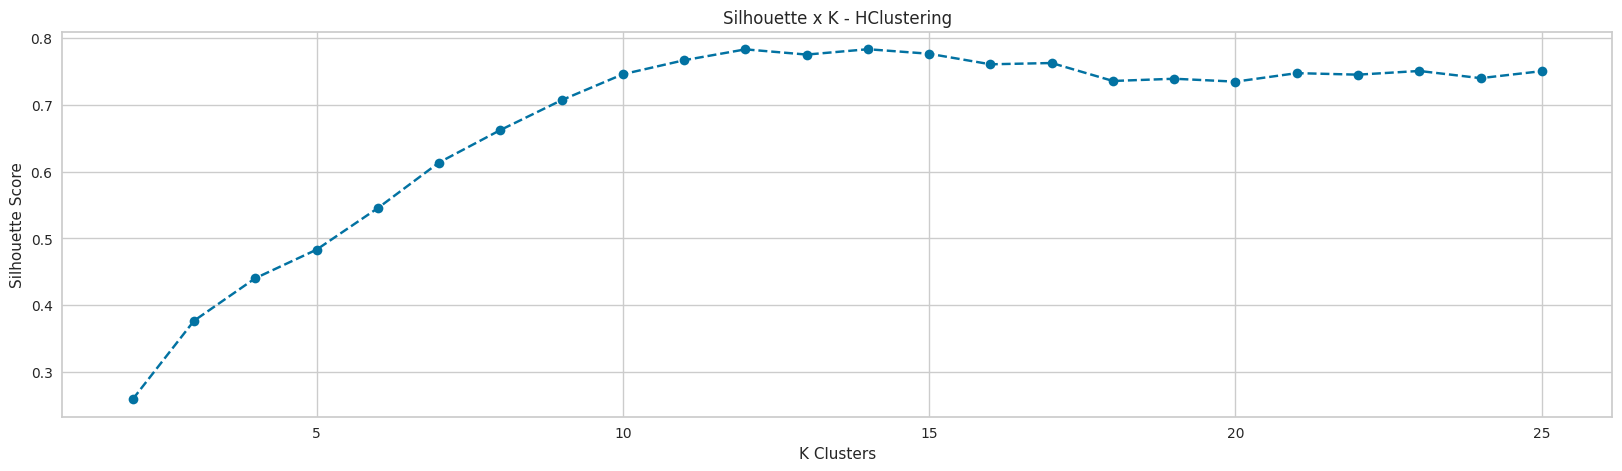

In [71]:
plt.figure(figsize=(20, 5))
plt.plot(clusters, hclustering_list, linestyle= '--', marker = 'o')
plt.xlabel('K Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette x K - HClustering')

## 7.4 DBSCAN

In [72]:
eps = 2.5
min_samples = 150

# model definition
dbscan_model = c.DBSCAN(eps = eps, min_samples=min_samples)

# model fit and predict
labels = dbscan_model.fit_predict(X)

# performance
ss = mt.silhouette_score(X, labels)
print('---Métrica DBSCAN---')
print(f'Silhouette Score: {ss}')
print(f'Número de Clusters: {len(np.unique(labels))}')
print(f'Cluster: {np.unique(labels)}')

---Métrica DBSCAN---
Silhouette Score: 0.6835615038871765
Número de Clusters: 11
Cluster: [-1  0  1  2  3  4  5  6  7  8  9]


## 7.5 Results

In [72]:
df_results = pd.DataFrame(
    {'Kmeans': kmeans_list,
    'GMM': gmm_list,
    'HClustering': hclustering_list}
).T
df_results.columns = clusters

In [73]:
df_results.style.highlight_max(color = 'blue', axis = 1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
Kmeans,0.257335,0.376584,0.409663,0.445078,0.526314,0.579240,0.629081,0.667717,0.741052,0.762171,0.751521,0.775340,0.783372,0.774716,0.776817,0.733805,0.731537,0.726904,0.700954,0.690233,0.682267,0.715317,0.650791,0.692165
GMM,0.200141,0.376584,0.415222,0.482298,0.543153,0.581758,0.629081,0.702295,0.741052,0.766883,0.783167,0.775340,0.764874,0.774716,0.767926,0.752204,0.720714,0.709730,0.716263,0.772181,0.731829,0.746385,0.717543,0.685053
HClustering,0.259112,0.376584,0.440322,0.483105,0.545353,0.613676,0.662289,0.707065,0.745888,0.766883,0.783167,0.775340,0.783372,0.776581,0.760796,0.762720,0.735815,0.739156,0.734802,0.747543,0.745275,0.750820,0.740046,0.750553


## 7.6 Silhouette Analysis

For K = 2: Silhouette Score: 0.25911247730255127
For K = 3: Silhouette Score: 0.37658366560935974
For K = 4: Silhouette Score: 0.4403216540813446
For K = 5: Silhouette Score: 0.4831046462059021
For K = 6: Silhouette Score: 0.5453532338142395
For K = 7: Silhouette Score: 0.6136763691902161
For K = 8: Silhouette Score: 0.6622889041900635
For K = 9: Silhouette Score: 0.7070653438568115
For K = 10: Silhouette Score: 0.7458879351615906
For K = 11: Silhouette Score: 0.766883373260498
For K = 12: Silhouette Score: 0.7831665277481079
For K = 13: Silhouette Score: 0.7753399610519409


IndexError: index 6 is out of bounds for axis 0 with size 6

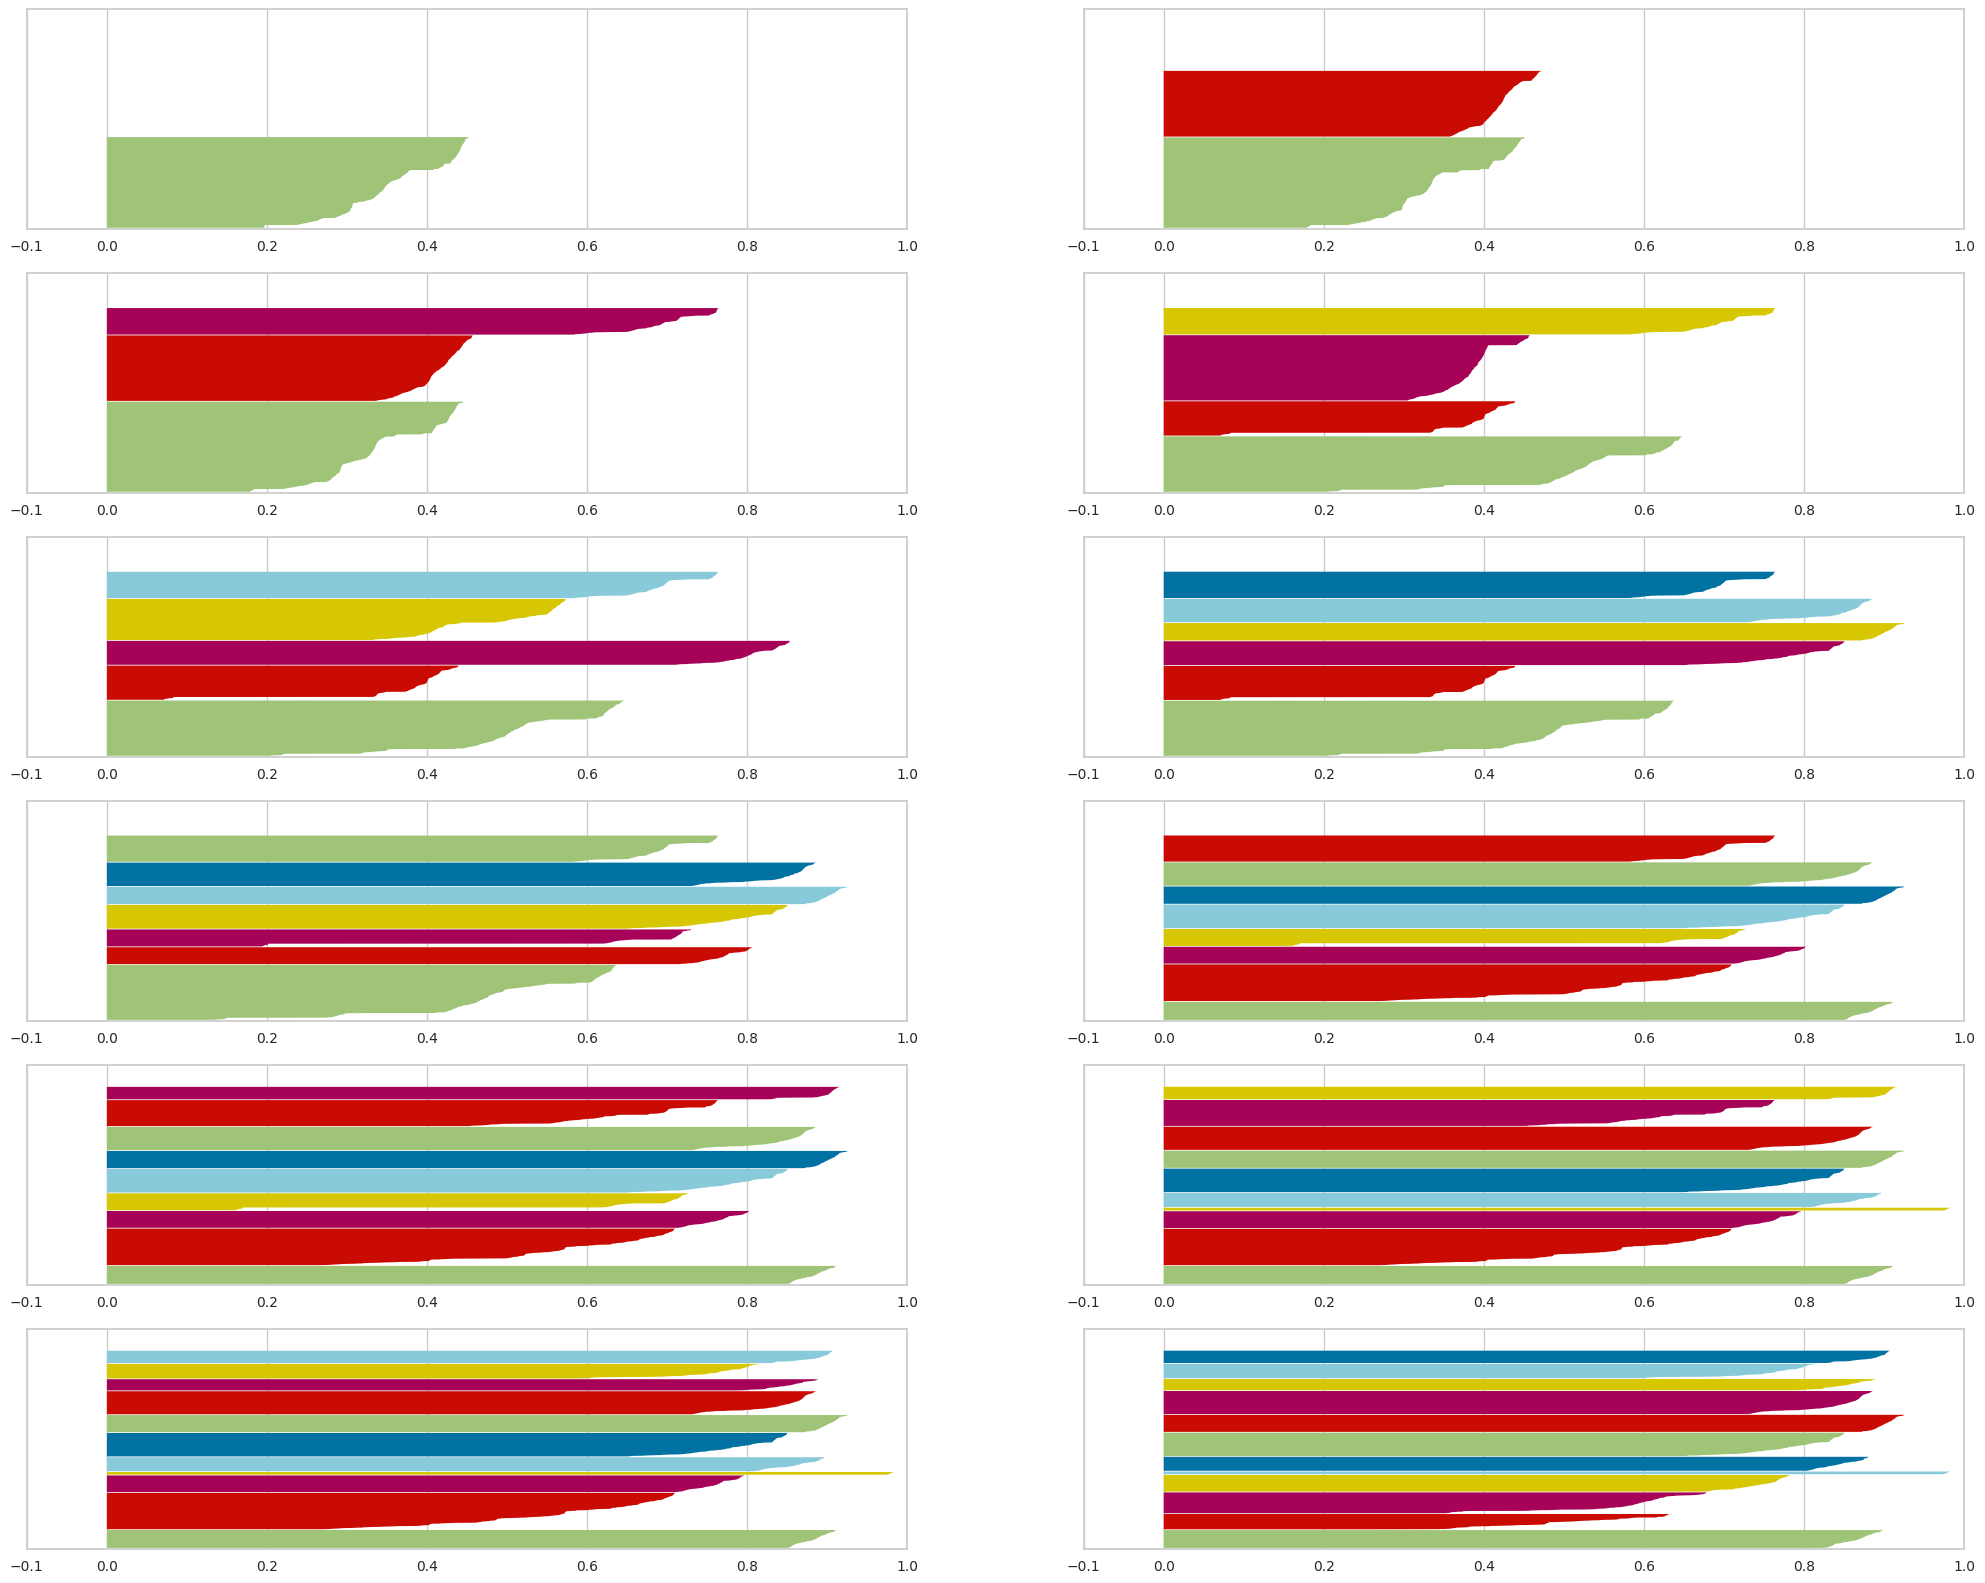

In [75]:
fig, ax = plt.subplots(6, 2)
fig.set_size_inches(25, 20)

for k in clusters:
    q, mod = divmod(k, 2)

    ax[q-1, mod].set_xlim(-0.1, 1)
    ax[q-1, mod].set_ylim(0, len(X) + (k+1) * 10)

    # model definition and training
    hc_model = hc.linkage(X, method='ward')

    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = mt.silhouette_score(X, labels)
    print(f'For K = {k}: Silhouette Score: {ss}')
    samples_silhouette_values = mt.silhouette_samples(X, labels)
    y_lower = 10

    for i in range(k):
        
        # select clusters
        ith_samples_silhouette_values = samples_silhouette_values[labels == i]
        
        # sort values
        ith_samples_silhouette_values.sort()


        # size cluster
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = plt.colormaps['Spectral']

        color = cmap(i/k)
        
        ax[q-1, mod].fill_betweenx( np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values )

        y_lower = y_upper + 10

    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 8.0 Model Training

## 8.1 K-Means

In [74]:
# model definition
k = 10
# kmeans = c.KMeans(n_clusters = k , random_state = 42)

# # model training
# kmeans.fit(X)

# # clustering
# labels = kmeans.labels_

hc_model = hc.linkage(X, method='ward')

    # model predict
labels = hc.fcluster(hc_model, k, criterion='maxclust')



### 8.2 Cluster Validation

In [75]:
print(f'SS:{mt.silhouette_score(X, labels)}')

SS:0.7458879351615906


# 9.0 Cluster Analysis

In [76]:
df9 = df4.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspection Silhouette

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/seaborn/_oldcore.py:1498:

<Axes: xlabel='embedding_x', ylabel='embedding_a'>

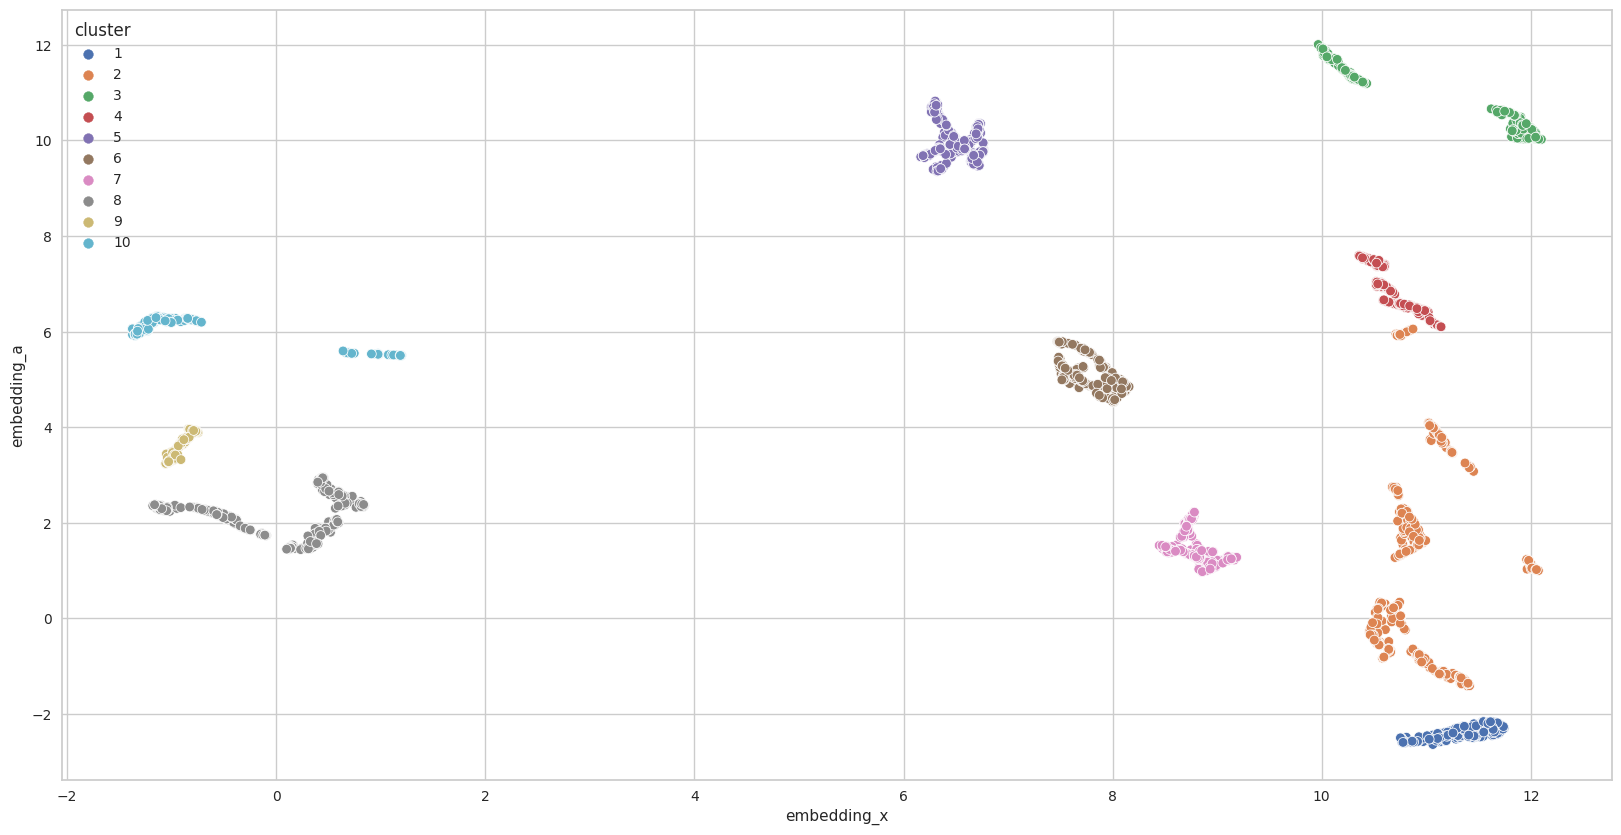

In [ ]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='embedding_x', y='embedding_a', data = df9, hue= 'cluster', palette='deep')

In [ ]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2 Cluster Profile

In [563]:
# Number of customers
df_cluster = df9[['customer_id','cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* (df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg gross_revenue
df_gross = df9[['gross_revenue','cluster']].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_gross, on='cluster', how='left')


# Avg recency_days
df_recency_days = df9[['recency_days','cluster']].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_recency_days, on='cluster', how='left')

# Avg purchases
df_purchases = df9[['purchases','cluster']].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_purchases, on='cluster', how='left')

# Avg items_purchased
df_items_purchased = df9[['items_purchased','cluster']].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_items_purchased, on='cluster', how='left')

# Avg number_returns
df_number_returns = df9[['number_returns','cluster']].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_number_returns, on='cluster', how='left')

# Avg monetary_returns
df_monetary_returns = df9[['monetary_returns','cluster']].groupby('cluster').median().reset_index()
df_cluster = pd.merge(df_cluster, df_monetary_returns, on='cluster', how='left')





df_cluster['avg_ticket'] = df_cluster.apply(lambda x: x['gross_revenue'] / x['purchases'], axis = 1)
df_cluster = df_cluster.drop('purchases', axis = 1)
df_cluster = np.round(df_cluster, 2)


cluster_names = {
    10: "Elite Insiders",
    9: "Top Consumers",
    8: "Potential",
    5: "Promising",
    6: "Sporadic Consumers",
    7: "Risky Segment",
    1: "Need Attention",
    2: "At Risk",
    4: "Churn Group",
    3: "Hibernating"
}

df_cluster['cluster'] = df_cluster['cluster'].map(cluster_names)

df_cluster = df_cluster.sort_values('gross_revenue', ascending = False).reset_index(drop = True)


In [564]:
df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,items_purchased,number_returns,monetary_returns,avg_ticket
0,Elite Insiders,291,9.81,6924.11,9.0,4428.0,3.0,67.25,494.58
1,Top Consumers,175,5.90,3794.52,15.0,2296.0,1.0,23.95,474.32
2,Potential,365,12.30,2527.92,24.0,1575.0,1.0,11.25,421.32
3,Promising,331,11.16,1735.18,26.0,1040.0,1.0,2.55,347.04
4,Sporadic Consumers,242,8.16,1334.52,28.0,791.0,0.0,0.00,333.63
5,Risky Segment,326,10.99,1047.53,35.5,587.5,0.0,0.00,349.18
6,Need Attention,252,8.49,789.90,44.0,440.5,0.0,0.00,263.30
7,At Risk,512,17.26,570.66,56.0,292.0,0.0,0.00,285.33
8,Churn Group,237,7.99,383.03,85.0,150.0,1.0,3.25,191.52
9,Hibernating,236,7.95,226.98,71.5,108.0,0.0,0.00,113.49


## 9.3 Teste de Hipóteses

### 9.3.1 Revenue

In [ ]:
insiders = df9.loc[(df9['cluster'] == 10), 'gross_revenue']
resto_base = df9.loc[~(df9['cluster'] == 10), 'gross_revenue']
top_consumers = df9.loc[(df9['cluster'] == 9), 'gross_revenue']

In [548]:
# Checando normalidade
print(stats.shapiro(top_consumers))
print(stats.shapiro(insiders))
print(stats.shapiro(resto_base))

## H0: Os dados são normais.
## H1: Os dados não são normais
### Rejeita Hipótese nula, então todos não seguem distribuição normal.

ShapiroResult(statistic=0.9610013961791992, pvalue=8.513133798260242e-05)
ShapiroResult(statistic=0.3668026924133301, pvalue=1.4383183367056914e-30)
ShapiroResult(statistic=0.8286941051483154, pvalue=0.0)


In [550]:
# Checando Variância
print(np.std(top_consumers))
print(np.std(insiders))
print(np.std(resto_base))

# Variância insiders / Variância Resto da Base > 4 
## Não apresentam variância igual
## Então escolha do MannWhitney - U

1396.0302441925428
29342.323620399136
1166.3293536378662


In [546]:

stat, pvalue = stats.mannwhitneyu(insiders, top_consumers)

# Cálculo das estatísticas de resumo
media_insiders = np.mean(insiders)
media_top_consumers = np.mean(top_consumers)
std_insiders = np.std(insiders)
std_top_consumers = np.std(top_consumers)

# Calculando o intervalo de confiança para a média de insiders
n1 = len(insiders)
conf_int1 = stats.t.interval(0.95, n1 - 1, loc=media_insiders, scale=std_insiders / np.sqrt(n1))

# Calculando o intervalo de confiança para a média de top_consumers
n2 = len(top_consumers)
conf_int2 = stats.t.interval(0.95, n2 - 1, loc=media_top_consumers, scale=std_top_consumers / np.sqrt(n2))

# Imprimindo os resultados
print("Estatística Mann-Whitney U:", stat)
print("Valor p:", pvalue)
print("Intervalo de confiança para a média de insiders:", conf_int1)
print("Intervalo de confiança para a média de top_consumers:", conf_int2)

Estatística Mann-Whitney U: 43987.0
Valor p: 1.5237707388729238e-39
Intervalo de confiança para a média de insiders: (11599.726279563525, 18370.563204972557)
Intervalo de confiança para a média de top_consumers: (3693.691035848705, 4110.258221294153)


In [ ]:
stat, pvalue = stats.mannwhitneyu(insiders, resto_base)
print("Estatística Mann-Whitney U:", stat)
print("Valor p:", pvalue)

In [547]:
stat, pvalue = stats.mannwhitneyu(insiders, resto_base)

# Cálculo das estatísticas de resumo
media_insiders = np.mean(insiders)
media_resto_base = np.mean(resto_base)
std_insiders = np.std(insiders)
std_resto_base = np.std(resto_base)

# Calculando o intervalo de confiança para a média de insiders
n1 = len(insiders)
conf_int1 = stats.t.interval(0.95, n1 - 1, loc=media_insiders, scale=std_insiders / np.sqrt(n1))

# Calculando o intervalo de confiança para a média de resto_base
n2 = len(resto_base)
conf_int2 = stats.t.interval(0.95, n2 - 1, loc=media_resto_base, scale=std_resto_base / np.sqrt(n2))

# Imprimindo os resultados
print("Estatística Mann-Whitney U:", stat)
print("Valor p:", pvalue)
print("Intervalo de confiança para a média de insiders:", conf_int1)
print("Intervalo de confiança para a média de resto_base:", conf_int2)



Estatística Mann-Whitney U: 764445.0
Valor p: 7.087022057936748e-161
Intervalo de confiança para a média de insiders: (11599.726279563525, 18370.563204972557)
Intervalo de confiança para a média de resto_base: (1296.9901568634466, 1385.410620416075)


### 9.3.2 Ticket Médio

In [551]:
insiders = df9.loc[(df9['cluster'] == 10), 'avg_ticket']
resto_base = df9.loc[~(df9['cluster'] == 10), 'avg_ticket']
top_consumers = df9.loc[(df9['cluster'] == 9), 'avg_ticket']

In [552]:
# Checando normalidade
print(stats.shapiro(top_consumers))
print(stats.shapiro(insiders))
print(stats.shapiro(resto_base))

## H0: Os dados são normais.
## H1: Os dados não são normais
### Rejeita Hipótese nula, então todos não seguem distribuição normal.

ShapiroResult(statistic=0.6668496131896973, pvalue=2.3281194795700445e-18)
ShapiroResult(statistic=0.5822879076004028, pvalue=6.770901617886412e-26)
ShapiroResult(statistic=0.7160424590110779, pvalue=0.0)


In [553]:
# Checando Variância
print(np.std(top_consumers))
print(np.std(insiders))
print(np.std(resto_base))

# Variância insiders / Variância Resto da Base < 4 
## Apresentam variância igual
### Apesar de ter a variância igual, não seguem distribuição normal.

428.13331099107734
944.6652413818202
254.2806992400617


In [554]:

stat, pvalue = stats.mannwhitneyu(insiders, top_consumers)

# Cálculo das estatísticas de resumo
media_insiders = np.mean(insiders)
media_top_consumers = np.mean(top_consumers)
std_insiders = np.std(insiders)
std_top_consumers = np.std(top_consumers)

# Calculando o intervalo de confiança para a média de insiders
n1 = len(insiders)
conf_int1 = stats.t.interval(0.95, n1 - 1, loc=media_insiders, scale=std_insiders / np.sqrt(n1))

# Calculando o intervalo de confiança para a média de top_consumers
n2 = len(top_consumers)
conf_int2 = stats.t.interval(0.95, n2 - 1, loc=media_top_consumers, scale=std_top_consumers / np.sqrt(n2))

# Imprimindo os resultados
print("Estatística Mann-Whitney U:", stat)
print("Valor p:", pvalue)
print("Intervalo de confiança para a média de insiders:", conf_int1)
print("Intervalo de confiança para a média de top_consumers:", conf_int2)

Estatística Mann-Whitney U: 31261.0
Valor p: 3.812555030241866e-05
Intervalo de confiança para a média de insiders: (739.9830905681434, 957.9676776528476)
Intervalo de confiança para a média de top_consumers: (493.6780246629977, 621.4304778042609)


In [555]:
stat, pvalue = stats.mannwhitneyu(insiders, resto_base)

# Cálculo das estatísticas de resumo
media_insiders = np.mean(insiders)
media_resto_base = np.mean(resto_base)
std_insiders = np.std(insiders)
std_resto_base = np.std(resto_base)

# Calculando o intervalo de confiança para a média de insiders
n1 = len(insiders)
conf_int1 = stats.t.interval(0.95, n1 - 1, loc=media_insiders, scale=std_insiders / np.sqrt(n1))

# Calculando o intervalo de confiança para a média de resto_base
n2 = len(resto_base)
conf_int2 = stats.t.interval(0.95, n2 - 1, loc=media_resto_base, scale=std_resto_base / np.sqrt(n2))

# Imprimindo os resultados
print("Estatística Mann-Whitney U:", stat)
print("Valor p:", pvalue)
print("Intervalo de confiança para a média de insiders:", conf_int1)
print("Intervalo de confiança para a média de resto_base:", conf_int2)



Estatística Mann-Whitney U: 628683.5
Valor p: 1.2251715172098066e-66
Intervalo de confiança para a média de insiders: (739.9830905681434, 957.9676776528476)
Intervalo de confiança para a média de resto_base: (328.56413829393614, 347.8413838071051)


### 9.3.3 Recência

In [557]:
insiders = df9.loc[(df9['cluster'] == 10), 'recency_days']
resto_base = df9.loc[~(df9['cluster'] == 10), 'recency_days']
top_consumers = df9.loc[(df9['cluster'] == 9), 'recency_days']

In [558]:
# Checando normalidade
print(stats.shapiro(top_consumers))
print(stats.shapiro(insiders))
print(stats.shapiro(resto_base))

## H0: Os dados são normais.
## H1: Os dados não são normais
### Rejeita Hipótese nula, então todos não seguem distribuição normal.

ShapiroResult(statistic=0.7132951021194458, pvalue=4.4584932446212235e-17)
ShapiroResult(statistic=0.509732723236084, pvalue=1.2025041460672331e-27)
ShapiroResult(statistic=0.7798707485198975, pvalue=0.0)


In [559]:
# Checando Variância
print(np.std(top_consumers))
print(np.std(insiders))
print(np.std(resto_base))

# Variância insiders / Variância Resto da Base < 4 
## Apresentam variância igual
### Apesar de ter a variância igual, não seguem distribuição normal -> Mann-Whitney U

34.46273160078515
38.41315629617884
79.42776157679232


In [560]:

stat, pvalue = stats.mannwhitneyu(insiders, top_consumers)

# Cálculo das estatísticas de resumo
media_insiders = np.mean(insiders)
media_top_consumers = np.mean(top_consumers)
std_insiders = np.std(insiders)
std_top_consumers = np.std(top_consumers)

# Calculando o intervalo de confiança para a média de insiders
n1 = len(insiders)
conf_int1 = stats.t.interval(0.95, n1 - 1, loc=media_insiders, scale=std_insiders / np.sqrt(n1))

# Calculando o intervalo de confiança para a média de top_consumers
n2 = len(top_consumers)
conf_int2 = stats.t.interval(0.95, n2 - 1, loc=media_top_consumers, scale=std_top_consumers / np.sqrt(n2))

# Imprimindo os resultados
print("Estatística Mann-Whitney U:", stat)
print("Valor p:", pvalue)
print("Intervalo de confiança para a média de insiders:", conf_int1)
print("Intervalo de confiança para a média de top_consumers:", conf_int2)

Estatística Mann-Whitney U: 20638.0
Valor p: 0.0006034799066799084
Intervalo de confiança para a média de insiders: (16.69860360977634, 25.562564775103382)
Intervalo de confiança para a média de top_consumers: (21.989690716743173, 32.27316642611397)


In [561]:
stat, pvalue = stats.mannwhitneyu(insiders, resto_base)

# Cálculo das estatísticas de resumo
media_insiders = np.mean(insiders)
media_resto_base = np.mean(resto_base)
std_insiders = np.std(insiders)
std_resto_base = np.std(resto_base)

# Calculando o intervalo de confiança para a média de insiders
n1 = len(insiders)
conf_int1 = stats.t.interval(0.95, n1 - 1, loc=media_insiders, scale=std_insiders / np.sqrt(n1))

# Calculando o intervalo de confiança para a média de resto_base
n2 = len(resto_base)
conf_int2 = stats.t.interval(0.95, n2 - 1, loc=media_resto_base, scale=std_resto_base / np.sqrt(n2))

# Imprimindo os resultados
print("Estatística Mann-Whitney U:", stat)
print("Valor p:", pvalue)
print("Intervalo de confiança para a média de insiders:", conf_int1)
print("Intervalo de confiança para a média de resto_base:", conf_int2)



Estatística Mann-Whitney U: 188498.5
Valor p: 1.7480137444623178e-47
Intervalo de confiança para a média de insiders: (16.69860360977634, 25.562564775103382)
Intervalo de confiança para a média de resto_base: (65.93021209844925, 71.95170120498871)


## 9.4 Previsão

In [345]:
clientes_insiders = df9.loc[(df9['cluster'] == 10), 'customer_id']
base_insiders = df3.loc[df3['customer_id'].isin(clientes_insiders), :]
base_insiders['gasto'] = base_insiders[['quantity','unit_price']].apply(lambda x: x['quantity'] * x['unit_price'], axis = 1)

In [347]:
base_insiders_treino = base_insiders[base_insiders['invoice_date'] <= '2017-11-07']
base_insiders_teste = base_insiders[base_insiders['invoice_date'] > '2017-11-07']
base_insiders_treino = base_insiders_treino[['invoice_date','gasto']].groupby(['invoice_date',]).sum().reset_index()
base_insiders_teste = base_insiders_teste[['invoice_date','gasto']].groupby(['invoice_date',]).sum().reset_index()

### Feature Engineering

In [352]:
base_insiders_treino['year'] = base_insiders_treino['invoice_date'].dt.year
base_insiders_treino['month'] = base_insiders_treino['invoice_date'].dt.month
base_insiders_treino['day'] = base_insiders_treino['invoice_date'].dt.day
base_insiders_treino['week_of_year'] = base_insiders_treino['invoice_date'].dt.isocalendar().week
base_insiders_treino['day_of_week'] = base_insiders_treino['invoice_date'].dt.dayofweek


base_insiders_treino = base_insiders_treino.drop('invoice_date', axis = 1).copy()


In [353]:
base_insiders_teste['year'] = base_insiders_teste['invoice_date'].dt.year
base_insiders_teste['month'] = base_insiders_teste['invoice_date'].dt.month
base_insiders_teste['day'] = base_insiders_teste['invoice_date'].dt.day
base_insiders_teste['week_of_year'] = base_insiders_teste['invoice_date'].dt.isocalendar().week
base_insiders_teste['day_of_week'] = base_insiders_teste['invoice_date'].dt.dayofweek
base_insiders_teste = base_insiders_teste.drop('invoice_date', axis = 1).copy()

### Preparação

In [354]:
base_insiders_treino['month_sin'] = base_insiders_treino['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) )
base_insiders_treino['month_cos'] = base_insiders_treino['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) )

base_insiders_treino['day_sin'] = base_insiders_treino['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 ) ) )
base_insiders_treino['day_cos'] = base_insiders_treino['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 ) ) )

base_insiders_treino['day_of_week_sin'] = base_insiders_treino['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 ) ) )
base_insiders_treino['day_of_week_cos'] = base_insiders_treino['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 ) ) )

base_insiders_treino['week_of_year_sin'] = base_insiders_treino['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 ) ) )
base_insiders_treino['week_of_year_cos'] = base_insiders_treino['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 ) ) )

In [355]:
base_insiders_teste['month_sin'] = base_insiders_teste['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) )
base_insiders_teste['month_cos'] = base_insiders_teste['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) )

base_insiders_teste['day_sin'] = base_insiders_teste['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 ) ) )
base_insiders_teste['day_cos'] = base_insiders_teste['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 ) ) )

base_insiders_teste['day_of_week_sin'] = base_insiders_teste['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 ) ) )
base_insiders_teste['day_of_week_cos'] = base_insiders_teste['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 ) ) )

base_insiders_teste['week_of_year_sin'] = base_insiders_teste['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 ) ) )
base_insiders_teste['week_of_year_cos'] = base_insiders_teste['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 ) ) )

## Feature Selection

In [356]:
base_insiders_treino['year'] = base_insiders_treino['year'].astype('int64')
base_insiders_treino['month'] = base_insiders_treino['month'].astype('int64')
base_insiders_treino['day'] = base_insiders_treino['day'].astype('int64')
base_insiders_treino['week_of_year'] = base_insiders_treino['week_of_year'].astype('int64')
base_insiders_treino['day_of_week'] = base_insiders_treino['day_of_week'].astype('int64')


base_insiders_teste['year'] = base_insiders_teste['year'].astype('int64')
base_insiders_teste['month'] = base_insiders_teste['month'].astype('int64')
base_insiders_teste['day'] = base_insiders_teste['day'].astype('int64')
base_insiders_teste['week_of_year'] = base_insiders_teste['week_of_year'].astype('int64')
base_insiders_teste['day_of_week'] = base_insiders_teste['day_of_week'].astype('int64')

In [357]:
day_encoder = base_insiders_treino.loc[:, ['day','gasto']].groupby('day').mean().reset_index()
week_of_year_encoder = base_insiders_treino.loc[:, ['week_of_year','gasto']].groupby('week_of_year').mean().reset_index()
day_of_week_encoder = base_insiders_treino.loc[:, ['day_of_week','gasto']].groupby('day_of_week').mean().reset_index()

base_insiders_treino['day'] = base_insiders_treino['day'].map(day_encoder.set_index('day')['gasto'])
base_insiders_treino['week_of_year'] = base_insiders_treino['week_of_year'].map(week_of_year_encoder.set_index('week_of_year')['gasto'])
base_insiders_treino['day_of_week'] = base_insiders_treino['day_of_week'].map(day_of_week_encoder.set_index('day_of_week')['gasto'])

In [358]:
base_insiders_teste['day'] = base_insiders_teste['day'].map(day_encoder.set_index('day')['gasto'])
base_insiders_teste['week_of_year'] = base_insiders_teste['week_of_year'].map(week_of_year_encoder.set_index('week_of_year')['gasto'])
base_insiders_teste['day_of_week'] = base_insiders_teste['day_of_week'].map(day_of_week_encoder.set_index('day_of_week')['gasto'])

In [92]:
base_insiders_treino['gasto'] = np.log1p( base_insiders_treino['gasto'])
base_insiders_treino['day'] = np.log1p( base_insiders_treino['day'])
base_insiders_treino['week_of_year'] = np.log1p( base_insiders_treino['week_of_year'])
base_insiders_treino['day_of_week'] = np.log1p( base_insiders_treino['day_of_week'])

base_insiders_teste['gasto'] = np.log1p( base_insiders_teste['gasto'])
base_insiders_teste['day'] = np.log1p( base_insiders_teste['day'])
base_insiders_teste['week_of_year'] = np.log1p( base_insiders_teste['week_of_year'])
base_insiders_teste['day_of_week'] = np.log1p( base_insiders_teste['day_of_week'])

/home/tiagobarreto/.pyenv/versions/3.11.4/envs/cluster/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [359]:
base_insiders_treino['gasto'].mean()

13332.692114695341

In [360]:
base_insiders_teste['week_of_year'] = base_insiders_teste['week_of_year'].fillna(13332.692114695341)

In [361]:
base_insiders_treino['gasto'] = base_insiders_treino['gasto'].fillna(0)

In [362]:
x_train = base_insiders_treino.drop(columns = ['gasto'], axis = 1)
y_treino = base_insiders_treino['gasto'].copy()

x_teste = base_insiders_teste.drop(columns = ['gasto'], axis = 1)
y_teste = base_insiders_teste['gasto'].copy()

## Dados para Previsão

In [ ]:
from datetime import datetime, timedelta

def generate_date_range(start_date, end_date):
    date_range = pd.date_range(start=start_date, end=end_date)
    return date_range

# Definindo o mês de início e fim desejado
start_date = '2017-12-08'
end_date = '2018-01-06'  

# Gerar a lista de datas
date_range = generate_date_range(start_date, end_date)

# Criar um DataFrame com as datas
df_testando = pd.DataFrame({'invoice_date': date_range})

# Exibir o DataFrame
df_testando['year'] = df_testando['invoice_date'].dt.year
df_testando['month'] = df_testando['invoice_date'].dt.month
df_testando['day'] = df_testando['invoice_date'].dt.day
df_testando['week_of_year'] = df_testando['invoice_date'].dt.isocalendar().week
df_testando['day_of_week'] = df_testando['invoice_date'].dt.dayofweek


df_testando = df_testando.drop('invoice_date', axis = 1).copy()



In [ ]:

df_testando['month_sin'] = df_testando['month'].apply(lambda x: np.sin(x * (2. * np.pi/12 ) ) )
df_testando['month_cos'] = df_testando['month'].apply(lambda x: np.cos(x * (2. * np.pi/12 ) ) )

df_testando['day_sin'] = df_testando['day'].apply(lambda x: np.sin(x * (2. * np.pi/30 ) ) )
df_testando['day_cos'] = df_testando['day'].apply(lambda x: np.cos(x * (2. * np.pi/30 ) ) )

df_testando['day_of_week_sin'] = df_testando['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7 ) ) )
df_testando['day_of_week_cos'] = df_testando['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7 ) ) )

df_testando['week_of_year_sin'] = df_testando['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52 ) ) )
df_testando['week_of_year_cos'] = df_testando['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52 ) ) )

df_testando


df_testando['year'] = df_testando['year'].astype('int64')
df_testando['month'] = df_testando['month'].astype('int64')
df_testando['day'] = df_testando['day'].astype('int64')
df_testando['week_of_year'] = df_testando['week_of_year'].astype('int64')
df_testando['day_of_week'] = df_testando['day_of_week'].astype('int64')



In [ ]:
df_testando['day'] = df_testando['day'].map(day_encoder.set_index('day')['gasto'])


In [ ]:
df_testando['week_of_year'] = df_testando['week_of_year'].map(week_of_year_encoder.set_index('week_of_year')['gasto'])


In [ ]:
df_testando['day_of_week'] = df_testando['day_of_week'].map(day_of_week_encoder.set_index('day_of_week')['gasto'])

In [ ]:
df_testando['day_of_week'] = df_testando['day_of_week'].fillna(13332.692114695341)

### Modelo

In [365]:
features_selected = ['day', 'day_cos', 'day_sin', 'day_of_week', 'day_of_week_sin', 'day_of_week_cos']

In [366]:
x_train = x_train[features_selected]
x_teste = x_teste[features_selected]

In [ ]:
df_predict = df_testando[features_selected]

### Rede Neural

In [ ]:
# def squared_error_of_sum(y_true, y_pred):
#     # Calculate the sum of predicted and true values
#     sum_pred = tf.reduce_sum(y_pred)
#     sum_true = tf.reduce_sum(y_true)
    
#     # Calculate the difference between the sums and normalize by the sum of true values
#     error = tf.abs((sum_pred - sum_true))

#     return error 

# model = tf.keras.Sequential([
#     tf.keras.layers.Dense(64, activation='linear', input_shape=(6,)),
#     tf.keras.layers.Dropout(0.8),
#     tf.keras.layers.Dense(32, activation='linear'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(16, activation='linear'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(8, activation='linear'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(4, activation='linear'),
#     tf.keras.layers.Dense(2, activation='linear'),
#     tf.keras.layers.Dense(1)  
# ])


# early_stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_loss',  # Monitora a métrica de perda no conjunto de validação
#     patience=50,            # Número de épocas sem melhoria antes de parar
#     restore_best_weights=True  # Restaurar os melhores pesos do modelo
# )


# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
#               loss=squared_error_of_sum, 
#               metrics=['mae'])  # Usando MAE como função de perda e métrica de avaliação


# # Treinamento do modelo
# from sklearn.model_selection import TimeSeriesSplit

# # Define o número de splits desejado
# n_splits = 2

# # Inicializa o TimeSeriesSplis
# tscv = TimeSeriesSplit(n_splits=n_splits)
# # Loop para iterar sobre os splits e fazer o treinamento/teste
# for train_index, val_index in tscv.split(x_train):
#     X_train, X_val = x_train.iloc[train_index], x_train.iloc[val_index]
#     y_train, y_val = y_treino.iloc[train_index], y_treino.iloc[val_index]

#     # Aqui você pode treinar o modelo usando X_train, y_train e validar com X_val, y_val
#     model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping_callback])



In [526]:


@register_keras_serializable()
def squared_error_of_sum(y_true, y_pred):
    # Calculate the sum of predicted and true values
    sum_pred = tf.reduce_sum(y_pred)
    sum_true = tf.reduce_sum(y_true)
    
    # Calculate the difference between the sums and normalize by the sum of true values
    error = tf.abs((sum_pred - sum_true))

    return error 

In [520]:
# # serialize model to JSON
# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
# model.save_weights("model.weights.h5")
# print("Saved model to disk")

Saved model to disk


In [522]:
from tensorflow.keras.models import Sequential, model_from_json

In [530]:
json_file = open('../models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../models/model.weights.h5")
print("Loaded model from disk")

Loaded model from disk


In [531]:
y_pred_test = loaded_model.predict(x_teste)

mae_test = mean_absolute_error((y_teste), (y_pred_test))



# Verificando a soma das previsões e dos valores reais
sum_y_pred = np.sum((y_pred_test))
sum_y_test = np.sum((y_teste))

print("MAE:", mae_test)
print("Soma das previsões:", sum_y_pred)
print("Soma dos valores reais:", sum_y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
MAE: 8291.795712139423
Soma das previsões: 460855.1
Soma dos valores reais: 525803.1900000001


In [492]:
abs((sum_y_pred - sum_y_test) / sum_y_test)

0.12352168546181709

In [532]:
y_pred_test = loaded_model.predict(df_predict)

sum_y_pred = np.sum((y_pred_test))
sum_y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


521493.0

In [533]:
sum_y_pred * (1 + 0.12352168546181709)

585908.6943165393

In [534]:
sum_y_pred * (1 + -0.12352168546181709)

457077.3056834606

## Reservado

In [500]:
y_pred_test = model.predict(x_teste)

mae_test = mean_absolute_error((y_teste), (y_pred_test))



# Verificando a soma das previsões e dos valores reais
sum_y_pred = np.sum((y_pred_test))
sum_y_test = np.sum((y_teste))

print("MAE:", mae_test)
print("Soma das previsões:", sum_y_pred)
print("Soma dos valores reais:", sum_y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
MAE: 8291.795712139423
Soma das previsões: 460855.1
Soma dos valores reais: 525803.1900000001


In [501]:
abs((sum_y_pred - sum_y_test) / sum_y_test)

0.12352168546181709

In [502]:
y_pred_test = model.predict(df_predict)

sum_y_pred = np.sum((y_pred_test))
sum_y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


521493.0

In [503]:
sum_y_pred * (1 + 0.12352168546181709)

585908.6943165393

In [504]:
sum_y_pred * (1 + -0.12352168546181709)

457077.3056834606

# 10.0 Análise Exploratória de Dados

In [320]:
df10 = df9.copy()

## 10.1 MindMap de Hipóteses

1. Fenômeno
2. Entidades (Customer, Location, Finance, Family)
3. Características da Entidade (Customer = Nome, Idade, Salário, Escolaridade)

## 10.2 Hipóteses de Negócio

1. Afirmação
2. Comparação entre variáveis
3. Valor base de comparação

### Hipóteses Compra

1. Os clientes do grupo insiders usam forma de pagamento à vista em 70% das compras.
2. **Os clientes do cluster insiders possuem um ticket médio 20% maior que o Elite Consumers.**
3. **Os clientes do cluster insiders possuem um Gross Revenue correspondente a 30% do Gross Revenue Total da empresa.**
4. **Os clientes do cluster insiders possuem um volume (itens) de compras 20% acima do total de compras.**
5. **50% dos clientes do cluster insiders compraram nos últimos 14 dias.**
6. **Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.**

### H1: Os clientes do cluster insiders possuem um ticket médio 20% maior que o Elite Consumers.
***Aceita: Os clientes do cluster insiders possuem um ticket médio 85% maior que o Elite Consumers.***


In [448]:
df_ticket_insiders = df_cluster.loc[df_cluster['cluster'] == 10, 'avg_ticket'].mean()
df_ticket_elite_consumers = df_cluster.loc[df_cluster['cluster'] == 9, 'avg_ticket'].mean()
print(f'Ticket Insiders: {np.round((df_ticket_insiders - df_ticket_elite_consumers)/df_ticket_elite_consumers, 2)}%')

Ticket Insiders: 0.85%


### H2: Os clientes do cluster insiders possuem um Gross Revenue correspondente a 30% do Gross Revenue Total da empresa.
***Aceita: O cluster insider possui um Gross Revenue de 54.85% do total da empresa.***

In [405]:
df_gmv_insiders = df10.loc[df10['cluster'] == 10, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()
print(f'GMV Insiders: {np.round(df_gmv_insiders/df_gmv_total * 100, 2)}%')

GMV Insiders: 54.85%


### H3: Os clientes do cluster insiders possuem um volume (itens) de compras correspondente a 40% do total de compras.
***Aceita: O cluster insider possuem um volume de compra de itens de 56.33%***

In [446]:
df_items_insiders = df10.loc[df10['cluster'] == 10, 'items_purchased'].sum()
df_items_total = df10.loc[:, 'items_purchased'].sum()
print(f'Items Insiders: {np.round((df_items_insiders)/df_items_total * 100, 2)}%')

Items Insiders: 56.33%


### H4: 50% dos clientes do cluster insiders compraram nos últimos 14 dias.
***Rejeitada: 50% dos clientes do cluster insiders compraram nos últimos 9 dias***

In [414]:
df_buy_fifty_porcent = df10.loc[df10['cluster'] == 10, 'recency_days'].median()
print(f'50% dos clientes do cluster insiders compraram nos últimos {df_buy_fifty_porcent} dias')

50% dos clientes do cluster insiders compraram nos últimos 9.0 dias


### H5: Os clientes do cluster insiders tem um número de devolução abaixo da média da base total de clientes.
***Rejeitada: O cluster insiders tem média de devoluções acima da média geral.***

In [422]:
df_returns_insiders = np.round(df10.loc[df10['cluster'] == 10, 'number_returns'].mean(), 0)
df_returns_total = np.round(df10.loc[:, 'number_returns'].mean(), 0)
print(f'Avg Returns Insiders: {df_returns_insiders} x Avg Returns All: {df_returns_total}')

Avg Returns Insiders: 4.0 x Avg Returns All: 1.0


### H6: A mediana do faturamento pelos clientes do cluster insiders é 50% maior que a mediana do faturamento geral
***Aceita: A mediana do faturamento é 539% acima da mediana.***

In [457]:
df_median_total = df10.loc[:, 'gross_revenue'].median()
df_median_insiders = df10.loc[df10['cluster'] == 10, 'gross_revenue'].median()
median_diff = 100 * np.round((df_median_insiders - df_median_total)/ df_median_total, 2)
print(f'Median Diff: {median_diff}%')

Median Diff: 539.0%


### Hipóteses Cliente

1. 70% dos clientes do grupo insiders possuem nível superior completo.
2. 60% dos clientes do grupo insiders tem entre 24 e 35 anos.
3. 40% dos clientes do grupo insiders são casados.
4. 30% dos clientes do grupo insiders tem filhos.
5. 90% dos clientes do grupo insiders estão dentro do Reino Unido
6. 10% do cluster insiders recebe mais de 100 mil dólares anualmente.

### Hipóteses Produto

1. 30% de todos os produtos em pacotes grandes são comprados pelos clientes do cluster insiders.
2. A mediana dos preços dos produtos comprados pelos clientes do cluster insider é 10% maior do que a mediana de todos os preços dos produtos.
3. O percentil do preço dos produtos comprados pelos clientes insiders.
4. O peso médio dos produtos comprados pelos clientes insiders é maior que o peso médio dos outros clusters.

## Perguntas de Négocio

### 1. Quem são as pessoas elegíveis para participar do programade de Insiders?



In [466]:
elegibles_customers = df10.loc[df10['cluster'] == 10, 'customer_id']


### 2. Quantos clientes farão parte do grupo?


In [468]:
elegibles_customers.size

291

### 3. Quais as principais características desses clientes?


#### Cluster 01: (Candidato à Insider)
    - Número de Customers: 291 (9.81% dos customers)
    - Faturamento Médio: $ 14,895.14
    - Recência em Média: 21 dias
    - Média de itens comprados: 9055
    - Números de Retornos em média: 4
    - Retorno Monetário em média: $ 395.37
    - Ticket médio $ 775.09

### 4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders?


In [477]:
df_gmv_insiders = df10.loc[df10['cluster'] == 10, 'gross_revenue'].sum()
df_gmv_total = df10.loc[:, 'gross_revenue'].sum()
print(f'Porcentagem de Contribuição do Faturamento: {np.round(df_gmv_insiders/df_gmv_total * 100, 2)}%')

Porcentagem de Contribuição do Faturamento: 54.85%


5. Qual a expectativa de faturamento desse grupo para os próximos meses?


6. Quais as condições para uma pessoa ser elegível ao Insiders?


7. Quais as condições para uma pessoa ser removida do Insiders?


8. Qual a garantia que o programa Insiders é melhor que o restante da base?


9. Quais ações o time de marketing podem realizar para aumentar o faturamento?

## 10.3 Priorização de Hipóteses

## 10.4 Validação de Hipóteses

## 10.5 Quadro de Respostas